In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from matplotlib.colors import ListedColormap


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import random
import matplotlib.ticker as mtick
import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from neighborhoods import admin_wards
from neighborhoods import district_neighborhoods

In [2]:
random.seed(42)

In [3]:
# Load the dataset
df = pd.read_csv('../data/processed/additional_data_cleaned_ER.csv')
df = df.dropna()
df.shape

(12515, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12515 entries, 0 to 12974
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  12515 non-null  int64  
 1   house_type             12515 non-null  object 
 2   house_type_2           12515 non-null  object 
 3   rooms                  12515 non-null  int64  
 4   m2                     12515 non-null  float64
 5   elevator               12515 non-null  int64  
 6   garage                 12515 non-null  int64  
 7   neighborhood           12515 non-null  object 
 8   district               12515 non-null  object 
 9   parking_spaces         12515 non-null  float64
 10  education_centers      12515 non-null  float64
 11  sports_centers         12515 non-null  float64
 12  social_wellness_index  12515 non-null  float64
 13  urban_mobility_index   12515 non-null  float64
 14  education_index        12515 non-null  float64
 15  em

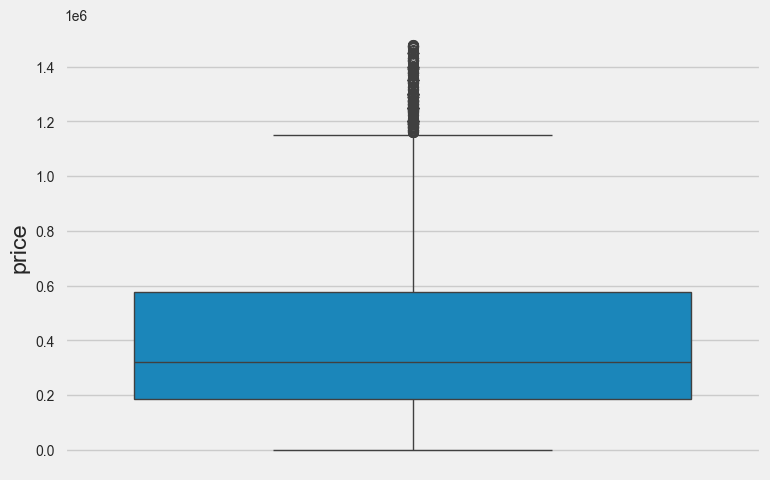

In [5]:
sns.boxplot(df['price'])
plt.show()

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
df.columns

Index(['price', 'house_type', 'house_type_2', 'rooms', 'm2', 'elevator',
       'garage', 'neighborhood', 'district', 'parking_spaces',
       'education_centers', 'sports_centers', 'social_wellness_index',
       'urban_mobility_index', 'education_index', 'employment_index',
       'health_index'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12515 entries, 0 to 12974
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  12515 non-null  int64  
 1   house_type             12515 non-null  object 
 2   house_type_2           12515 non-null  object 
 3   rooms                  12515 non-null  int64  
 4   m2                     12515 non-null  float64
 5   elevator               12515 non-null  int64  
 6   garage                 12515 non-null  int64  
 7   neighborhood           12515 non-null  object 
 8   district               12515 non-null  object 
 9   parking_spaces         12515 non-null  float64
 10  education_centers      12515 non-null  float64
 11  sports_centers         12515 non-null  float64
 12  social_wellness_index  12515 non-null  float64
 13  urban_mobility_index   12515 non-null  float64
 14  education_index        12515 non-null  float64
 15  em

In [9]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [10]:
df_corr = pd.DataFrame(df[numerical_features].corr()['price'])
df_corr['price'] = df_corr['price'].apply(lambda x: abs(x))
df_corr.sort_values(by='price', ascending=False)

,price
price,1.000000
m2,0.773464
employment_index,0.543103
rooms,0.492842
education_index,0.471814
elevator,0.357822
garage,0.272081
urban_mobility_index,0.191040
parking_spaces,0.187931
social_wellness_index,0.173914


In [11]:
df = df[[column for column in df.columns if column != 'sports_centers' 
        and column != 'education_centers' 
        and column != 'health_index'
        and column != 'social_wellness_index'
        ]]


In [12]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'price']]
y = df['price']

In [13]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [23]:
# cluster_errors = []

# for n_clusters in range(2, 11):
#     kmeans_pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ("pca", PCA(10, svd_solver='arpack')),
#         ("cluster", KMeans(n_clusters=n_clusters, random_state=42, verbose=0))
#     ])
#     kmeans_pipeline.fit(X)
#     wcsse = kmeans_pipeline.named_steps["cluster"].inertia_
#     print('K = ', n_clusters, '\tWCSS Err. = ', wcsse)
#     cluster_errors.append(wcsse)

# plt.plot(range(2, 11), cluster_errors, "o-")
# plt.xlabel("No. Clusters")
# plt.ylabel("SSE")
# plt.show()

In [24]:
# silhouette_s = []

# for n_clusters in range(2, 11):
#     kmeans_pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ("pca", PCA(10, svd_solver='arpack')),
#         ("cluster", KMeans(n_clusters=n_clusters))])
#     df_X = kmeans_pipeline.fit_transform(X)
#     cluster_labels = kmeans_pipeline.fit_predict(X)
#     print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(df_X, cluster_labels).round(4))
#     silhouette_s.append(silhouette_score(df_X, cluster_labels))

# plt.plot(range(2, 11),silhouette_s, "o-")
# plt.xlabel("No. Clusters")
# plt.ylabel("Silhouette Score")
# plt.show()


In [25]:
pipe_pca_kmean = Pipeline(
        [
          ('preprocessor', preprocessor),
          ('pca', PCA(5, svd_solver='arpack')),
          ("cluster", KMeans(n_clusters=2, verbose=0))
        ]
    )
pipe_pca_kmean.fit(X)
pipe_pca_kmean.predict(X)

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [26]:
kmean_cluster = pd.DataFrame(
    data = pipe_pca_kmean.named_steps["cluster"].labels_,
    index = X.index,
    columns=['kmean_cluster']
)

In [27]:
kmean_cluster


,kmean_cluster
0,1
1,1
2,1
3,1
4,1
...,...
12970,0
12971,0
12972,0
12973,0


In [28]:
kmean_cluster['kmean_cluster'].value_counts()

1    7742
0    4773
Name: kmean_cluster, dtype: int64

In [29]:
X['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [30]:
df['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [31]:
df['price'] = df['price'].apply(lambda x: round(x, 2))
pd.options.display.float_format = '{:.2f}'.format

df_combined_describe_dict = {}
columns = []

df_0 = df[df['kmean_cluster']==0]
df_0_y_describe = df_0['price'].describe()
df_combined_describe_dict['df_0'] = df_0_y_describe
columns.append(('Price', 'Cluster 0'))

df_1 = df[df['kmean_cluster']==1]
df_1_y_describe = df_1['price'].describe()
df_combined_describe_dict['df_1'] = df_1_y_describe
columns.append(('Price', 'Cluster 1'))

# df_2 = df[df['kmean_cluster']==2]
# df_2_y_describe = df_2['price'].describe()
# df_combined_describe_dict['df_2'] = df_2_y_describe
# columns.append(('Price', 'Cluster 2'))

df_combined_describe = pd.DataFrame(df_combined_describe_dict)

multi_index = pd.MultiIndex.from_tuples(columns)

df_combined_describe.columns = multi_index

df_combined_describe

Price           
       Cluster 0  Cluster 1
count    4773.00    7742.00
mean   206493.04  563980.23
std    103810.27  319224.95
min       725.00   75000.00
25%    140000.00  313944.50
50%    177900.00  475000.00
75%    245000.00  765000.00
max   1049900.00 1480000.00

In [32]:
tsne = Pipeline(
        [
          ('preprocessor', preprocessor),
          ("tsne", TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init='random')),
        ]
    )

X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 12515 samples in 0.001s...
[t-SNE] Computed neighbors for 12515 samples in 4.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12515
[t-SNE] Computed conditional probabilities for sample 2000 / 12515
[t-SNE] Computed conditional probabilities for sample 3000 / 12515
[t-SNE] Computed conditional probabilities for sample 4000 / 12515
[t-SNE] Computed conditional probabilities for sample 5000 / 12515
[t-SNE] Computed conditional probabilities for sample 6000 / 12515
[t-SNE] Computed conditional probabilities for sample 7000 / 12515
[t-SNE] Computed conditional probabilities for sample 8000 / 12515
[t-SNE] Computed conditional probabilities for sample 9000 / 12515
[t-SNE] Computed conditional probabilities for sample 10000 / 12515
[t-SNE] Computed conditional probabilities for sample 11000 / 12515
[t-SNE] Computed conditional probabilities for sample 12000 / 12515
[t-SNE] Computed conditional probabilities for sa

In [33]:
le = LabelEncoder()

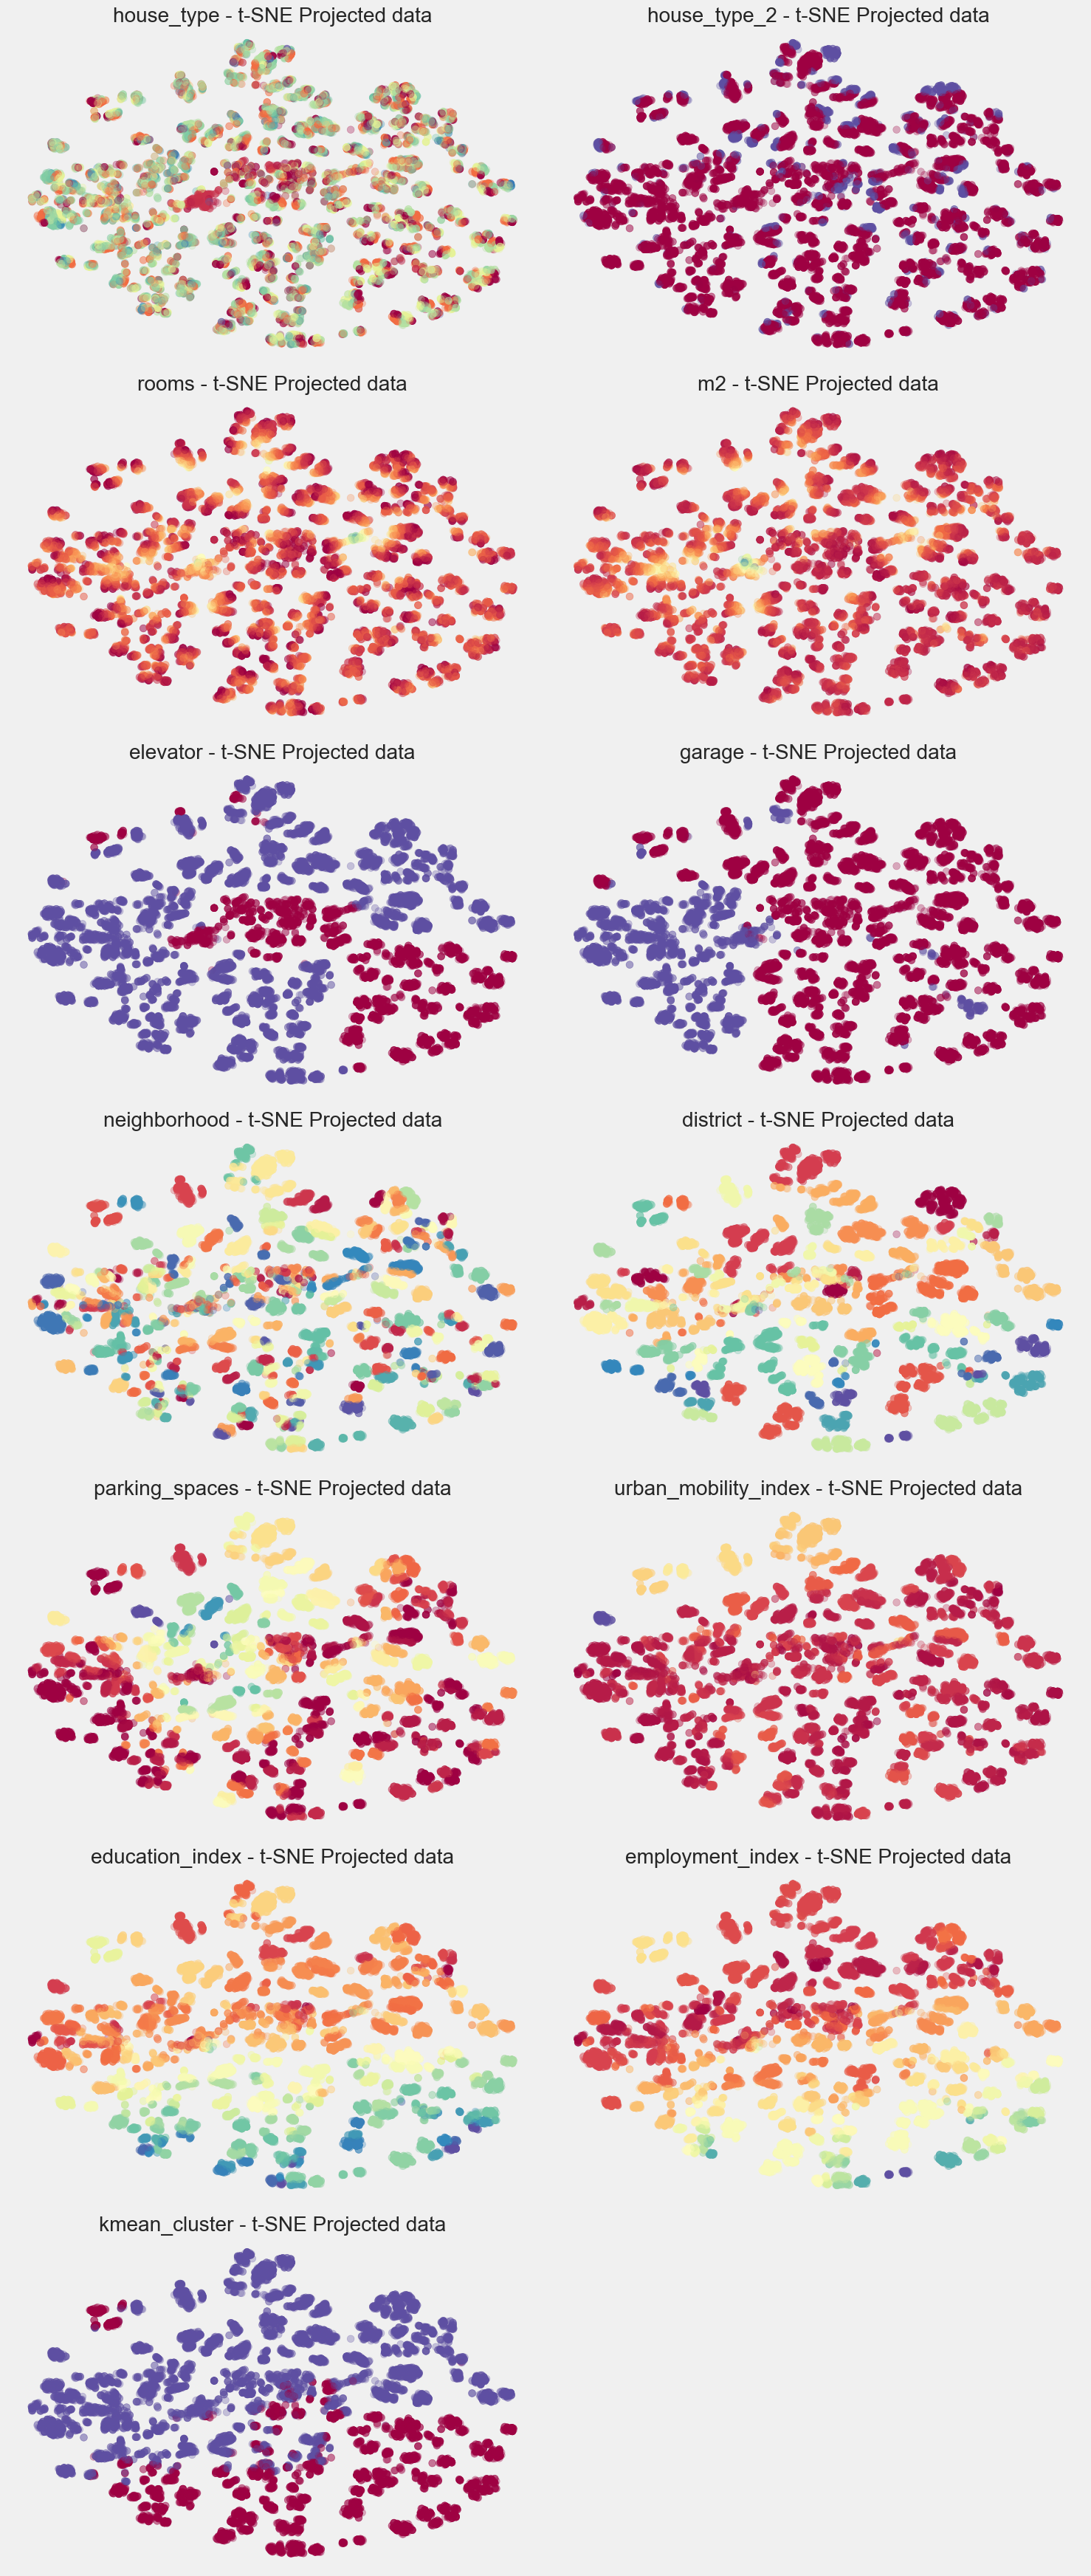

In [34]:
nrows = 16
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (15, 5*nrows))

axs = axs.flatten()

le = LabelEncoder()

cluster_colors = ['#69ACD9', '#E8917D', '#E2C480']
custom_cmap = ListedColormap(cluster_colors)

for i, column in enumerate(X.columns):
    if i >= len(axs):
        break
    ax = axs[i]
    if column in categorical_features:
        encoded_column = le.fit_transform(df[column])
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=encoded_column, cmap=plt.cm.Spectral, alpha=0.3)
    # elif column=='kmean_cluster':
    #     scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=encoded_column, cmap=custom_cmap, alpha=0.3)
    else:
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[column], cmap=plt.cm.Spectral, alpha=0.3)

    ax.set_title(f'{column} - t-SNE Projected data')
    ax.axis('tight')
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [35]:
num_features_plot = ['price', 'm2']

In [36]:
def plot_clusters(column, df_list, numerical_features, figsize, rotate=False):
    print(rotate)
    if column in numerical_features:
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        for i, df in enumerate(df_list):
            sns.kdeplot(data=df, x=column, ax=ax, label=f'Cluster {i}', shade=True)
        ax.set_title(f'KDE Plot - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.legend()
        if rotate:
            plt.xticks(rotation=360)
    else:
        cluster_colors = ['#69ACD9', '#E8917D', '#E2C480']
        combined_df = pd.concat([df.assign(cluster=i) for i, df in enumerate(df_list)])
        proportions = combined_df.groupby([column, 'cluster']).size().reset_index(name='count')
        proportions['proportion'] = proportions.groupby(column)['count'].apply(lambda x: x / float(x.sum()))
        pivot_df = proportions.pivot(index=column, columns='cluster', values='proportion').fillna(0)
        pivot_df = pivot_df.sort_values(by=0)
        fig, ax = plt.subplots(figsize=figsize)
        pivot_df.plot(kind='bar', stacked=True, ax=ax, color=cluster_colors[:pivot_df.shape[1]])
        ax.set_title(f'Relative Proportions - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Proportion')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        if rotate:
            plt.xticks(rotation=90)
        else:
            plt.xticks(rotation=0)
    plt.show()

False


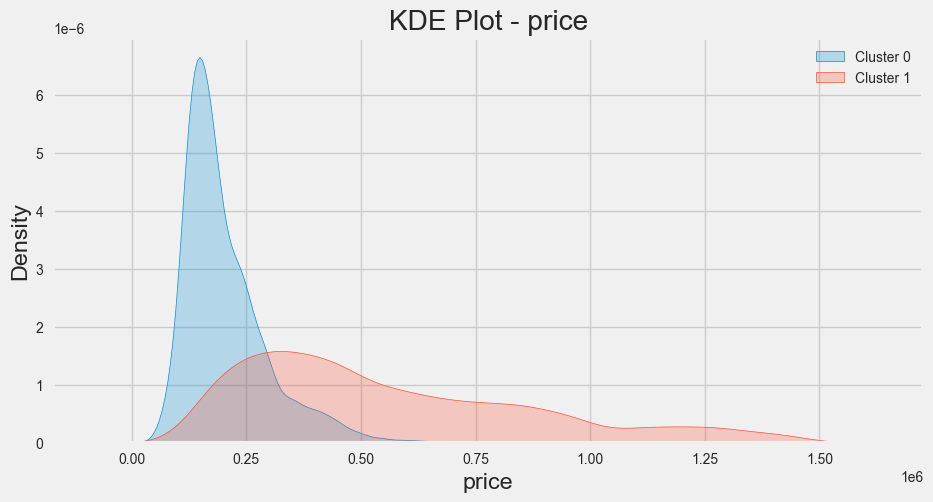

In [37]:
plot_clusters('price', [df_0, df_1], num_features_plot, (10,5))

False


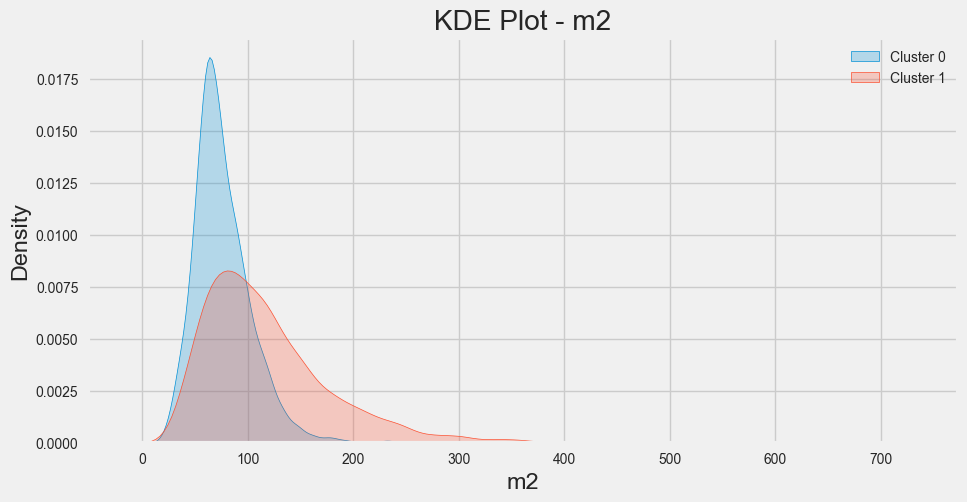

In [38]:
plot_clusters('m2', [df_0, df_1], num_features_plot, (10,5))

True


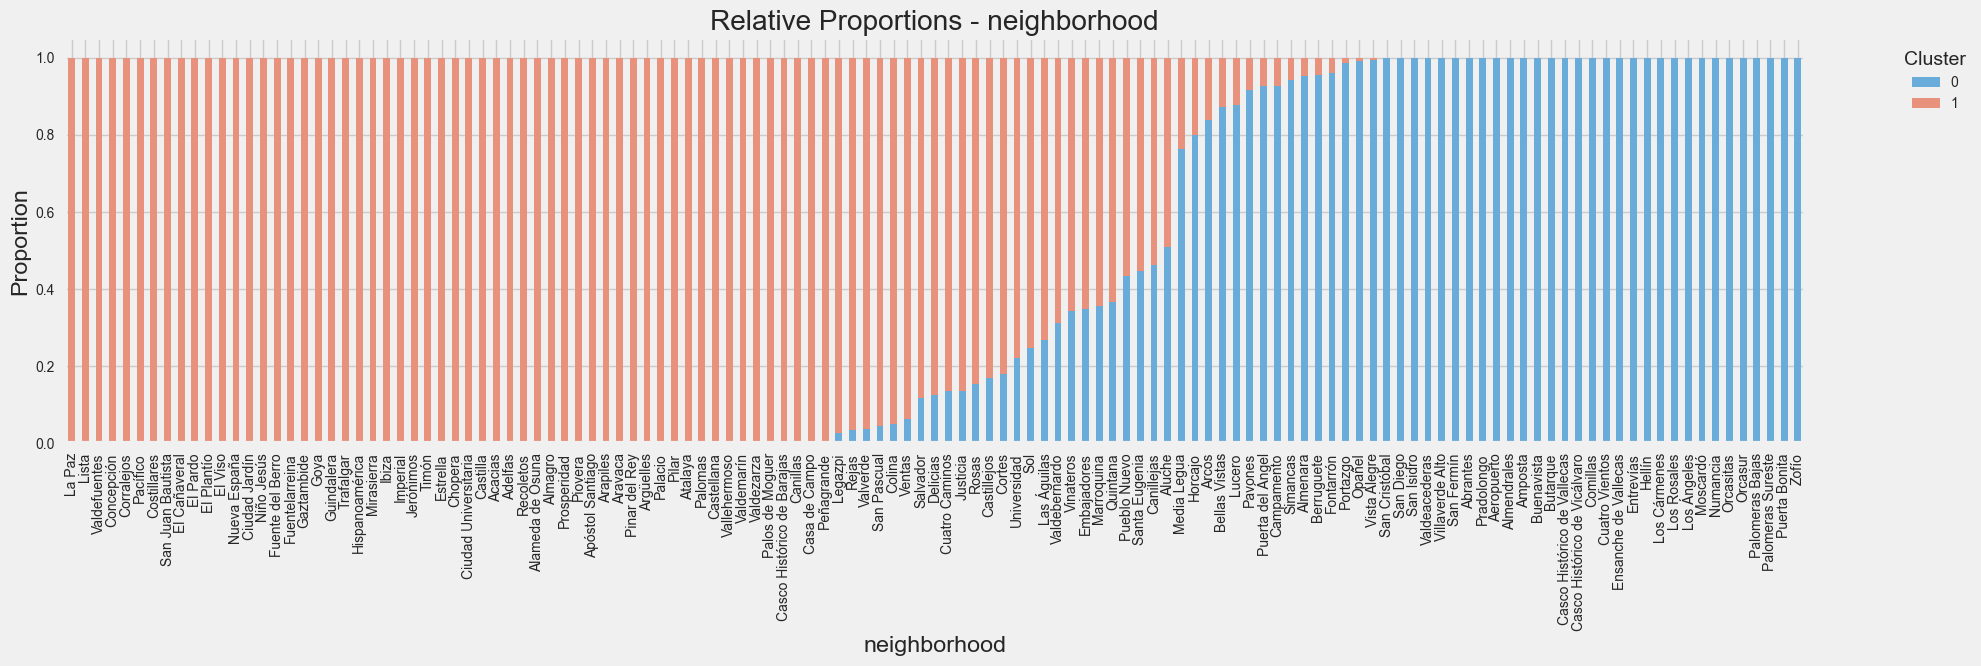

In [39]:
plot_clusters('neighborhood', [df_0, df_1], num_features_plot, (20, 5), True)

In [40]:
df_0 = df_0.drop(columns='kmean_cluster')
df_1 = df_1.drop(columns='kmean_cluster')

In [41]:
df_0.to_csv('../data/processed/additional_data_cluster_0.csv', index=False)
df_1.to_csv('../data/processed/additional_data_cluster_1.csv', index=False)